In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

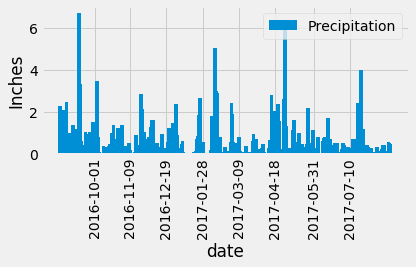

<Figure size 432x288 with 0 Axes>

In [10]:
# Calculate the date 1 year ago from the last data point in the database
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_date_from_db = str(session.query(measurement.date).order_by(measurement.date.desc()).first()).strip('(),\'')
#print(latest_date_from_db)
latest_date_from_db = datetime.strptime(latest_date_from_db, '%Y-%m-%d')
#print(date_dt3)
one_year_ago_date = latest_date_from_db - relativedelta(months=12)
#print(one_year_ago_date)

# Perform a query to retrieve the data and precipitation scores
# honolulu_station_code = engine.execute('SELECT station FROM station WHERE name LIKE \"%HONOLULU%\" ').fetchall()
# print(honolulu_station_code)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.DataFrame(session.query(measurement.date,measurement.prcp).\
        filter(measurement.date > one_year_ago_date).\
        order_by(measurement.date).all())
prcp_data = prcp_data.fillna(0)
prcp_data = prcp_data.set_index('date')

# Sort the dataframe by date
prcp_data = prcp_data.sort_index()
prcp_data.head()

# Use Pandas Plotting with Matplotlib to plot the data
tick_locations = ['2016-10-01', '2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']
tick_labels = ['2016-10-01', '2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']

plt.bar(prcp_data.index,prcp_data['prcp'],label="Precipitation",width=4)
plt.xlabel("date")
plt.ylabel("Inches")
plt.legend()
plt.xticks(tick_locations, tick_labels, rotation="vertical")
plt.tight_layout()
plt.show()
plt.savefig("Precipitation_and_dates.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
print("Total Number of Stations:")
session.query(measurement).group_by(measurement.station).count()

Total Number of Stations:


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.read_sql_query(session.query(Station.name,measurement.station,func.count(measurement.tobs)).\
    filter(measurement.station == Station.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.prcp).desc()).statement ,session.bind)
print("Most Active Stations:")
active_stations

Most Active Stations:


,name,station,count_1
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"KANEOHE 838.1, HI US",USC00513117,2709
2,"WAIKIKI 717.2, HI US",USC00519397,2724
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations.iloc[active_stations['count_1'].idxmax(),1]
#print(most_active_station)
statement = session.query(Station.name,measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == Station.station).\
    filter(measurement.station == most_active_station).all()

for record in statement:
    (nam,station, minimum, maximum,average) = record
    print(f"The Most active station is: '{nam}' with ID {station}")
    print(f"The Mimimum, Maximum and Average temprature of the station is: '{minimum}, {maximum}, {round(average,2)}'.")


The Most active station is: 'WAIHEE 837.5, HI US' with ID USC00519281
The Mimimum, Maximum and Average temprature of the station is: '54.0, 85.0, 71.66'.


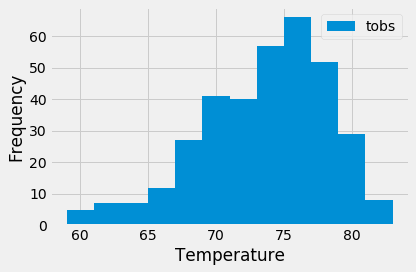

<Figure size 432x288 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
statement = session.query(measurement.date,measurement.tobs).\
    filter(measurement.station == most_active_station).filter(measurement.date > one_year_ago_date).statement

summary = pd.read_sql_query(statement,session.bind)
#summary.head()

summary.plot.hist(summary['tobs'],bins=12)
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()
plt.savefig("Temprature_frequency.png")

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-02-28'
end_date = '2017-03-05'
result = calc_temps(start_date,end_date)
(tmin,tavg,tmax) = result[0]
print(tmin,tavg,tmax)

64.0 72.02777777777777 78.0


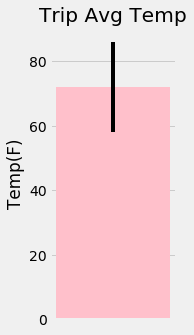

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(x=20,height = tavg,width = 0.35,color = "pink",yerr = tmax-tmin)
plt.ylabel("Temp(F)")
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()
plt.savefig("Trip_avg_temp_bar_graph.png")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
statement = session.query(measurement.station, Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(measurement.prcp)).\
    filter(measurement.station == Station.station).\
    filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
    group_by(measurement.station).\
    order_by(func.sum(measurement.prcp).desc()).statement
summary = pd.read_sql_query(statement,session.bind)
summary

,station,name,latitude,longitude,elevation,sum_1
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
import numpy as np
normals = []
# Set the start and end date of the trip
start_date = '2017-02-28'
end_date = '2017-03-05'
# Use the start and end date to create a range of dates
mydates = pd.date_range(start_date, end_date).tolist()

# Stip off the year and save a list of %m-%d strings
mynewdates = [x.strftime('%m-%d') for x in mydates]
# Loop through the list of %m-%d strings and calculate the normals for each date
for x in mynewdates:
    normals.append(np.ravel(daily_normals(x)))
    
normals

[array([65.        , 70.65517241, 80.        ]),
 array([64.        , 70.03278689, 76.        ]),
 array([61.        , 70.36666667, 78.        ]),
 array([60.        , 70.06896552, 78.        ]),
 array([57.        , 69.27272727, 77.        ]),
 array([60.        , 67.89090909, 76.        ])]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals,index=mynewdates,columns=['min_temp','avg_temp','max_temp'])
df

,min_temp,avg_temp,max_temp
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


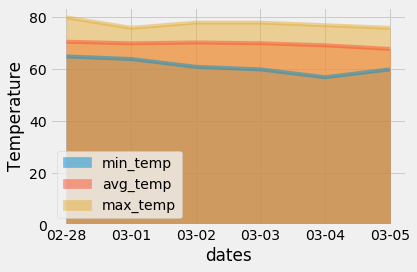

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.xlabel("dates")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()
plt.savefig("Temprature_and_trip_date_area_graph.png")

#### Ttest on Average Temp of June and December.
We have used the unpaired ttest, as we have one depent variable here (Temprature) and two independent variables i.e. months June and December.
Null hypothesis : There is no significant difference in the temprature in months june and december.

In [24]:
import scipy.stats as stats
# list of temp of june over the years
statement = session.query(measurement.tobs).\
    filter(func.strftime("%m", measurement.date) == '06').statement
june_data = pd.read_sql_query(statement,session.bind)

# list of temp in December over the years
statement = session.query(measurement.tobs).\
    filter(func.strftime("%m", measurement.date) == '12').statement
december_data = pd.read_sql_query(statement,session.bind)

#do the ttest
stats.ttest_ind(june_data, december_data, equal_var=False)



Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

After doing ttest we have observed pvalue to be less then threshold value i.e. .05 So we Reject the null hypothesis. Which means there is significant difference between the temprature means in both the months.